In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pathlib
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

<IPython.core.display.Javascript object>

In [3]:
def create_output_directory(fpath):
    """Creates output directory for images, if it doesn't already exist"""
    pathlib.Path(fpath).mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

In [4]:
output_images_dir = "./output_images/"
output_data_dir = "./output_data/"

test_images_input_dir = "./test_images/"

<IPython.core.display.Javascript object>

# Calibrate Camera

- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
- images in `camera_cal/` have chessboard size $9x6$

In [5]:
chess_w = 9
chess_h = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ... (6, 4, 0)
# by creating six by eight points in an array
# each with three columns for the x, y, and z coordinates of each corner
# initialize these all as zeros using Numpy's zero function
objp = np.zeros((chess_w * chess_h, 3), np.float32)

# z coordinate will stay zero but for first two columns, x and y
# use numpy's mgrid function to generate the coordinates that we want
# mgrid returns the coordinate values for a given grid size
# shape those coordinates back into two columns, one for x and one for y
objp[:, :2] = np.mgrid[0:chess_w, 0:chess_h].T.reshape(-1, 2)  # x, y coordinates

camera_calibration_input_dir = "./camera_cal/"

camera_calibration_chessboard_corners_output_dir = (
    output_images_dir + "1_camera_calibration_output_images/chessboard_corners/"
)
create_output_directory(camera_calibration_chessboard_corners_output_dir)

# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in os.listdir(camera_calibration_input_dir):
    # Read in each image
    img = cv2.imread(camera_calibration_input_dir + fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_w, chess_h), None)

    # If corners are found, add object points, image points
    if ret == True:
        objpoints.append(
            objp
        )  # these object points will be the same for all of the calibration images, since they represent a real chessboard

        # increase corner accuracy
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (chess_w, chess_h), corners, ret)

        # plt.figure()
        # plt.imshow(img)

        # save image
        cv2.imwrite(camera_calibration_chessboard_corners_output_dir + fname, img)

<IPython.core.display.Javascript object>

In [6]:
camera_calibration_undistorted_output_dir = (
    output_images_dir + "1_camera_calibration_output_images/undistorted/"
)
create_output_directory(camera_calibration_undistorted_output_dir)

# Test undistortion on an image
img = cv2.imread("./camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_size, None, None
)

# undistort image
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite(output_images_dir + "calibration1.jpg", undist_img)

True

<IPython.core.display.Javascript object>

In [7]:
# save calculated camera matrix and distortion coefficients
calibrate_camera_data = {"mtx": mtx, "dist": dist}
# store data (serialize)
with open(output_data_dir + "calibrate_camera_data.pickle", "wb") as handle:
    pickle.dump(calibrate_camera_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

In [8]:
# undistort test images
for fname in os.listdir(test_images_input_dir):
    # Read in each image
    img = cv2.imread(test_images_input_dir + fname)
    # undistort image
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    # save image
    cv2.imwrite(camera_calibration_undistorted_output_dir + fname, img_undist)

<IPython.core.display.Javascript object>

# Perspective Transform

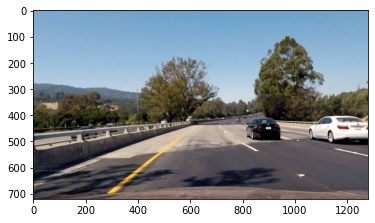

<IPython.core.display.Javascript object>

In [9]:
# load example undistorted image
undist_img = cv2.imread(
    "./output_images/1_camera_calibration_output_images/undistorted/test4.jpg"
)  # BGR image

plt.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))

In [10]:
# Four source coordinates (region of interest)
perspective_src = np.float32(
    [
        (575, 465),  # top left
        (715, 465),  # top right
        (260, 685),  # bottom left
        (1055, 685),  # bottom right
    ]
)

y_size = undist_img.shape[0]  # height
x_size = undist_img.shape[1]  # width

# Four desired coordinates (region of interest)
perspective_dst = np.float32(
    [
        (450, 0),  # top left
        (x_size - 450, 0),  # top right
        (450, y_size),  # bottom left
        (x_size - 450, y_size),  # bottom right
    ]
)

<IPython.core.display.Javascript object>

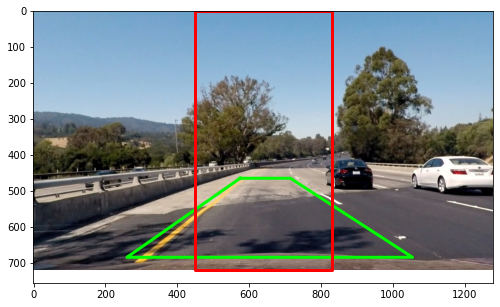

<IPython.core.display.Javascript object>

In [11]:
_, ax = plt.subplots(figsize=(10, 5))
ax.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))

perspective_src_x = [
    perspective_src[0][0],
    perspective_src[2][0],
    perspective_src[3][0],
    perspective_src[1][0],
    perspective_src[0][0],
]
perspective_src_y = [
    perspective_src[0][1],
    perspective_src[2][1],
    perspective_src[3][1],
    perspective_src[1][1],
    perspective_src[0][1],
]

# plot four source coordinates (region of interest) - green area
ax.plot(perspective_src_x, perspective_src_y, color="#00ff00", linewidth=3)

perspective_dst_x = [
    perspective_dst[0][0],
    perspective_dst[2][0],
    perspective_dst[3][0],
    perspective_dst[1][0],
    perspective_dst[0][0],
]
perspective_dst_y = [
    perspective_dst[0][1],
    perspective_dst[2][1],
    perspective_dst[3][1],
    perspective_dst[1][1],
    perspective_dst[0][1],
]

# plot four desired coordinates (region of interest) - red area
ax.plot(perspective_dst_x, perspective_dst_y, color="#ff0000", linewidth=3)

In [12]:
# Define perspective transform function
def warp(img, src, dst):

    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])

    # Compute the perspective transform, M (matrix)
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse also by swapping the input parameters
    M_inv = cv2.getPerspectiveTransform(dst, src)

    # Create warped image using the perspective transform, M - uses linear interpolation
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return img_warped, M_inv

<IPython.core.display.Javascript object>

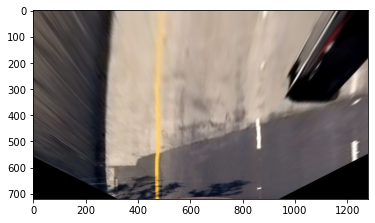

<IPython.core.display.Javascript object>

In [13]:
# apply perspective transform on example undistorted image
warped_img, inv_M = warp(undist_img, perspective_src, perspective_dst)

plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [14]:
perspective_transform_output_dir = (
    output_images_dir + "2_perspective_transform_output_images/"
)
create_output_directory(perspective_transform_output_dir)

# warp undistorted test images
for fname in os.listdir(camera_calibration_undistorted_output_dir):
    # Read in each image
    img = cv2.imread(camera_calibration_undistorted_output_dir + fname)
    # warp image
    img_warped, _ = warp(img, perspective_src, perspective_dst)
    # save image
    cv2.imwrite(perspective_transform_output_dir + fname, img_warped)

<IPython.core.display.Javascript object>

# Color Spaces and Thresholding

In [15]:
# Visualize multiple color space channels

# HLS
warped_img_HLS = cv2.cvtColor(warped_img, cv2.COLOR_BGR2HLS)
warped_img_HLS_H = warped_img_HLS[:, :, 0]
warped_img_HLS_L = warped_img_HLS[:, :, 1]
warped_img_HLS_S = warped_img_HLS[:, :, 2]

# HSV
warped_img_HSV = cv2.cvtColor(warped_img, cv2.COLOR_BGR2HSV)
warped_img_HSV_H = warped_img_HSV[:, :, 0]
warped_img_HSV_S = warped_img_HSV[:, :, 1]
warped_img_HSV_V = warped_img_HSV[:, :, 2]

# LAB
warped_img_LAB = cv2.cvtColor(warped_img, cv2.COLOR_BGR2LAB)
warped_img_LAB_L = warped_img_LAB[:, :, 0]
warped_img_LAB_A = warped_img_LAB[:, :, 1]
warped_img_LAB_B = warped_img_LAB[:, :, 2]

# LUV
warped_img_LUV = cv2.cvtColor(warped_img, cv2.COLOR_BGR2LUV)
warped_img_LUV_L = warped_img_LUV[:, :, 0]
warped_img_LUV_U = warped_img_LUV[:, :, 1]
warped_img_LUV_V = warped_img_LUV[:, :, 2]

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'LUV V-Channel')

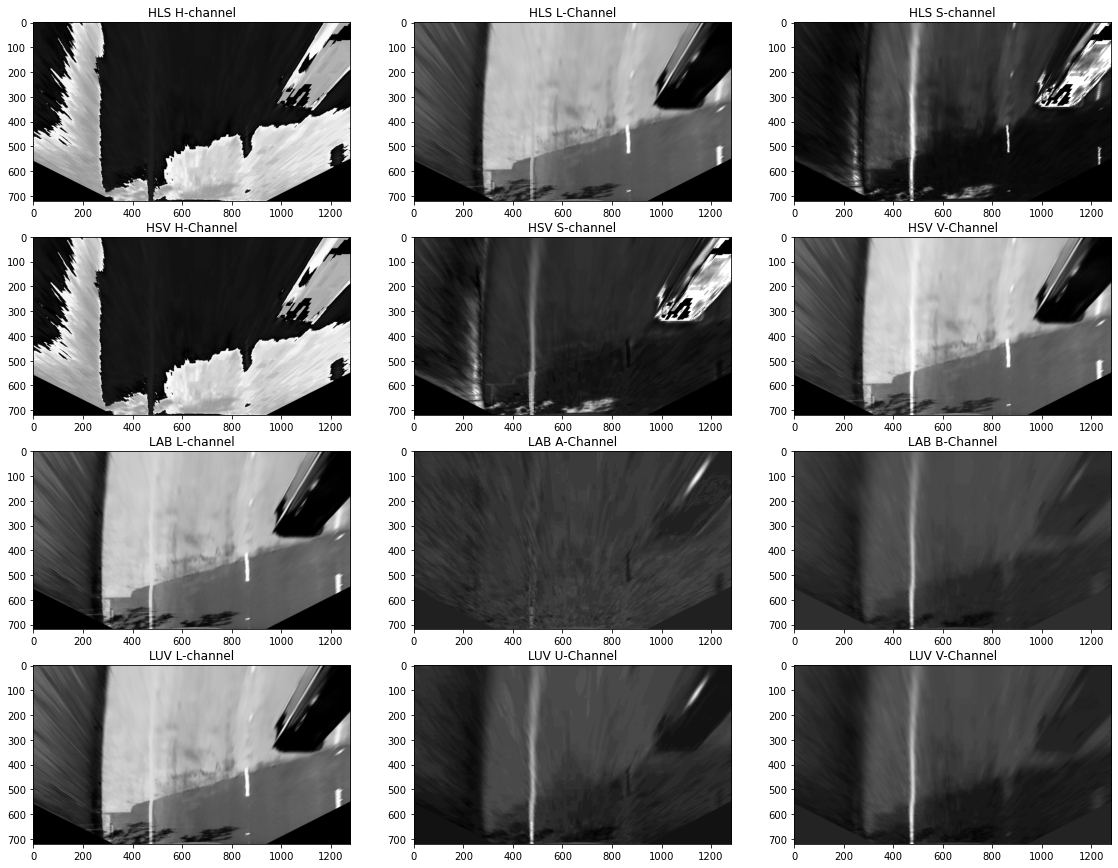

<IPython.core.display.Javascript object>

In [16]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
fig.tight_layout(h_pad=1.5)
axs = axs.ravel()

axs[0].imshow(warped_img_HLS_H, cmap="gray")
axs[0].set_title("HLS H-channel")
axs[1].imshow(warped_img_HLS_L, cmap="gray")
axs[1].set_title("HLS L-Channel")
axs[2].imshow(warped_img_HLS_S, cmap="gray")
axs[2].set_title("HLS S-channel")


axs[3].imshow(warped_img_HSV_H, cmap="gray")
axs[3].set_title("HSV H-Channel")
axs[4].imshow(warped_img_HSV_S, cmap="gray")
axs[4].set_title("HSV S-channel")
axs[5].imshow(warped_img_HSV_V, cmap="gray")
axs[5].set_title("HSV V-Channel")


axs[6].imshow(warped_img_LAB_L, cmap="gray")
axs[6].set_title("LAB L-channel")
axs[7].imshow(warped_img_LAB_A, cmap="gray")
axs[7].set_title("LAB A-Channel")
axs[8].imshow(warped_img_LAB_B, cmap="gray")
axs[8].set_title("LAB B-Channel")


axs[9].imshow(warped_img_LUV_L, cmap="gray")
axs[9].set_title("LUV L-channel")
axs[10].imshow(warped_img_LUV_U, cmap="gray")
axs[10].set_title("LUV U-Channel")
axs[11].imshow(warped_img_LUV_V, cmap="gray")
axs[11].set_title("LUV V-Channel")

In [17]:
# combine HLS-S, LUV-L and LAB-B channels


def color_threshold(img_warped):
    hls_s_channel = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS)[:, :, 2]

    lab_b_channel = cv2.cvtColor(img_warped, cv2.COLOR_BGR2LAB)[:, :, 2]

    luv_l_channel = cv2.cvtColor(img_warped, cv2.COLOR_BGR2LUV)[:, :, 0]

    # threshold color channels
    hls_s_thresh = (180, 255)
    hls_s_binary = np.zeros_like(hls_s_channel)
    hls_s_binary[
        (hls_s_channel >= hls_s_thresh[0]) & (hls_s_channel <= hls_s_thresh[1])
    ] = 1

    lab_b_thresh = (155, 200)
    lab_b_binary = np.zeros_like(lab_b_channel)
    lab_b_binary[
        (lab_b_channel >= lab_b_thresh[0]) & (lab_b_channel <= lab_b_thresh[1])
    ] = 1

    luv_l_thresh = (225, 255)
    luv_l_binary = np.zeros_like(luv_l_channel)
    luv_l_binary[
        (luv_l_channel >= luv_l_thresh[0]) & (luv_l_channel <= luv_l_thresh[1])
    ] = 1

    img_color_threshold = np.zeros_like(hls_s_binary)
    img_color_threshold[(luv_l_binary == 1) | (lab_b_binary == 1)] = 1

    return img_color_threshold

<IPython.core.display.Javascript object>

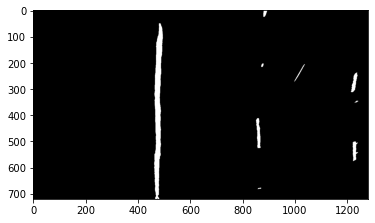

<IPython.core.display.Javascript object>

In [18]:
color_threshold_img = color_threshold(warped_img)

plt.imshow(color_threshold_img, "gray")

In [19]:
color_threshold_output_dir = output_images_dir + "3_color_threshold_output_images/"
create_output_directory(color_threshold_output_dir)


# apply color treshold to warped images
for fname in os.listdir(perspective_transform_output_dir):
    # Read in each image
    img = cv2.imread(perspective_transform_output_dir + fname)
    # apply color threshold to warped image
    img_color_threshold = color_threshold(img)
    # save image
    # multiply with 255 to see pixels
    cv2.imwrite(color_threshold_output_dir + fname, img_color_threshold * 255)

<IPython.core.display.Javascript object>

# Histogram Peaks

In [20]:
# Define a function for plotting a histogram of where the binary activations occur across the image
def hist(img_color_threshold):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img_color_threshold[img_color_threshold.shape[0] // 2 :, :]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    # Take a histogram along all the columns in the lower half of the image
    histogram = np.sum(bottom_half, axis=0)

    return histogram

<IPython.core.display.Javascript object>

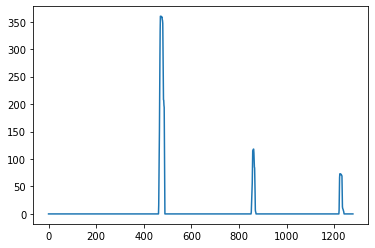

<IPython.core.display.Javascript object>

In [21]:
# Create histogram of image binary activations
histogram = hist(color_threshold_img)

# Visualize the resulting histogram
plt.plot(histogram)

# Sliding Window

In [22]:
# Define a function to fit polynomials to binary image with lines extracted using sliding window


def sliding_window_polyfit(img_color_threshold):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(
        img_color_threshold[img_color_threshold.shape[0] // 2 :, :], axis=0
    )

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS - related to our sliding windows
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_color_threshold.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_color_threshold.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Rectangles data for sliding windows visualization
    rectangles_visualization_data = []

    # 1. Loop through each window in nwindows

    # 2. Find the boundaries of our current window.
    #    This is based on a combination of the current window's starting point
    #    (leftx_current and rightx_current), as well as the margin you set in the hyperparameters.

    # 3. Use cv2.rectangle to draw these window boundaries onto our visualization image out_img.
    #    This is required for the quiz, but you can skip this step in practice if you don't need
    #    to visualize where the windows are.

    # 4. Now that we know the boundaries of our window, find out which activated pixels from
    #    nonzeroy and nonzerox above actually fall into the window.

    # 5. Append these to our lists left_lane_inds and right_lane_inds.

    # 6. If the number of pixels you found in Step 4 are greater than your hyperparameter minpix,
    #    re-center our window (i.e. leftx_current or rightx_current) based on the mean position of these pixels.

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_color_threshold.shape[0] - (window + 1) * window_height
        win_y_high = img_color_threshold.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Append visualization data
        rectangles_visualization_data.append(
            (
                win_y_low,
                win_y_high,
                win_xleft_low,
                win_xleft_high,
                win_xright_low,
                win_xright_high,
            )
        )

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xleft_low)
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xright_low)
            & (nonzerox < win_xright_high)
        ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each side/lane
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    return (
        left_fit,
        right_fit,
        left_lane_inds,
        right_lane_inds,
        rectangles_visualization_data,
    )

<IPython.core.display.Javascript object>

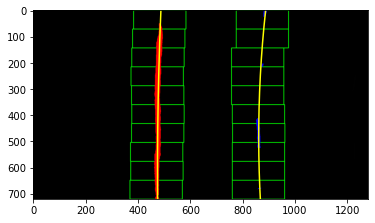

<IPython.core.display.Javascript object>

In [23]:
# Visualize sliding windows polyfit on example image

left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles_visualization_data = sliding_window_polyfit(
    color_threshold_img
)

# Create an output image to draw on and visualize the result
sliding_windows_polyfit_img = np.dstack(
    (color_threshold_img, color_threshold_img, color_threshold_img)
)

# Generate x and y values for plotting
ploty = np.linspace(0, color_threshold_img.shape[0] - 1, color_threshold_img.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

for rect in rectangles_visualization_data:
    # Draw the windows on the visualization image
    cv2.rectangle(
        sliding_windows_polyfit_img,
        (rect[2], rect[0]),  # (win_xleft_low, win_y_low)
        (rect[3], rect[1]),  # (win_xleft_high, win_y_high)
        (0, 255, 0),
        2,
    )
    cv2.rectangle(
        sliding_windows_polyfit_img,
        (rect[4], rect[0]),  # (win_xright_low, win_y_low)
        (rect[5], rect[1]),  # (win_xright_high, win_y_high)
        (0, 255, 0),
        2,
    )

# Identify the x and y positions of all nonzero pixels in the image
nonzero = color_threshold_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

sliding_windows_polyfit_img[
    nonzeroy[left_lane_inds], nonzerox[left_lane_inds]  # lefty, leftx
] = [255, 0, 0]
sliding_windows_polyfit_img[
    nonzeroy[right_lane_inds], nonzerox[right_lane_inds]  # righty, rightx
] = [0, 0, 255]

# plot sliding windows on detected lane lines
plt.imshow(sliding_windows_polyfit_img)

# plot left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color="yellow")
plt.plot(right_fitx, ploty, color="yellow")

# Search from Prior

In [24]:
def search_around_poly(img_color_threshold, left_fit_prev, right_fit_prev, margin=80):
    # margin parameter is the width of the margin around the previous polynomial to search

    # Grab activated pixels
    nonzero = img_color_threshold.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = (
        nonzerox
        > (
            left_fit_prev[0] * (nonzeroy ** 2)
            + left_fit_prev[1] * nonzeroy
            + left_fit_prev[2]
            - margin
        )
    ) & (
        nonzerox
        < (
            left_fit_prev[0] * (nonzeroy ** 2)
            + left_fit_prev[1] * nonzeroy
            + left_fit_prev[2]
            + margin
        )
    )
    right_lane_inds = (
        nonzerox
        > (
            right_fit_prev[0] * (nonzeroy ** 2)
            + right_fit_prev[1] * nonzeroy
            + right_fit_prev[2]
            - margin
        )
    ) & (
        nonzerox
        < (
            right_fit_prev[0] * (nonzeroy ** 2)
            + right_fit_prev[1] * nonzeroy
            + right_fit_prev[2]
            + margin
        )
    )

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each side/lane
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

<IPython.core.display.Javascript object>

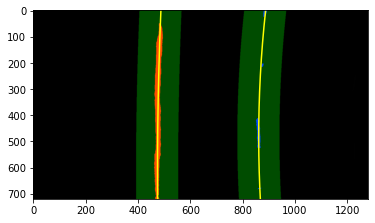

<IPython.core.display.Javascript object>

In [25]:
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = search_around_poly(
    color_threshold_img, left_fit, right_fit
)

# Generate x and y values for plotting
left_fitx2 = left_fit2[0] * ploty ** 2 + left_fit2[1] * ploty + left_fit2[2]
right_fitx2 = right_fit2[0] * ploty ** 2 + right_fit2[1] * ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((color_threshold_img, color_threshold_img, color_threshold_img))
window_img = np.zeros_like(out_img)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = color_threshold_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

margin = 80

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
left_line_window2 = np.array(
    [np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))]
)
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
right_line_window2 = np.array(
    [np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))]
)
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color="yellow")
plt.plot(right_fitx, ploty, color="yellow")